# Path planning application

## Imports and constants

In [11]:
import math
import time

import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt, patches
from matplotlib.lines import Line2D
import pandas as pd

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize

from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder

from itertools import combinations

C = 343.                                                 
NFFT = 256   
ROOM_DIM = [5.,5.]
SNR = 0.001                                               

AUDIO_PATH = '..\\data\\original\\arctic_a0200.wav'

## Utils

### CNN

To predict using CNN:
- load the CNN model as:        
`
model = load_model('../models/INSERT_MODEL_NAME', compile = True) 
`

- create GCC_PHAT matrix frim .wav file:        
`
X = create_observations(INSER_SIGNAL, INSERT_FRAMES)
`

- get prediction in degrees:        
`
encoder = encode()
`                                               
`
pred = get_CNN_prediction(X, model, encoder)
`

In [12]:
# CNN
def gcc_phat(x_1, x_2, FS=16000, interp=1):    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
    # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See Knapp and Carter (1976) for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.2 m is the distance between the micropones and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.2 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def compute_gcc_matrix(observation, fs, interp=1):    
    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    mic_1, mic_2 = [0, 1]
    x_1 = observation[:, mic_1]
    x_2 = observation[:, mic_2]

    gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

    # Add the GCC vector to the GCC matrix
    transformed_observation.append(gcc)    
        
    return transformed_observation


def create_observations(wav_signals, fs, samples=20, step=5, interp=1):
    # Lists of observations and labels that will be populated
    X = []
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
              
        # Transform observation into a GCC matrix
        X.append(compute_gcc_matrix(observation, fs, interp=interp))

    cols = [
                f'mics{mic_1+1}{mic_2+1}_{i}' 
                    for mic_1, mic_2 in combinations(range(2), r=2) 
                        for i in range(np.shape(X)[2])
            ]

    df = pd.DataFrame(data=np.reshape(X, (len(X), -1)), columns=cols)
    
    return df


def encode():
    x = list(range(0, 180 + 1, 10))
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit([[label] for label in x])
    return encoder


def get_CNN_prediction(X, model, encoder):
    t0_cnn = time.time()
    predictions = model.predict(X)
    y_pred = encoder.inverse_transform(predictions)

    t1_cnn = time.time()
    print(f'CNN prediction time: {t1_cnn - t0_cnn:.4f}s')

    predictions=[]
    for i in y_pred:
        predictions.append(int(i))

    pred_degree = max(set(predictions), key=predictions.count)
    pred_rad = math.pi - pred_degree*math.pi/180
    
    return pred_rad

### MUSIC

- Run MUSIC by calling:                 
`
pred = MUSIC(INSERT_SIMUALATED_ROOM, INSERT_MICROPHONE, INSERT_SFFT_MATRIX, FRAMES)
`

In [13]:
def get_doa_MUSIC(room, microphones, fs):
    X = pra.transform.stft.analysis(room.mic_array.signals.T, NFFT, NFFT // 2)
    X = X.transpose([2, 1, 0])

    # Construct the new DOA object and perform localization on the frames in X
    t0_m = time.time()
    doa = pra.doa.MUSIC(microphones, fs, NFFT, c=C, num_src=1)
    doa.locate_sources(X)
    pred = doa.azimuth_recon

    if pred > np.pi:
        pred = (2 * np.pi - pred)

    t1_m = time.time()
    print(f"MUSIC time taken: {t1_m - t0_m:.4f}s")

    return pred

### Room

In [14]:
def create_room(signal, fs, source_loc, centre_mic):
    room = pra.ShoeBox(ROOM_DIM, fs=fs, max_order=0)
    room.add_source(source_loc, signal=signal)

    microphones = np.c_[[centre_mic[0]-0.1, centre_mic[1]], [centre_mic[0]+0.1, centre_mic[1]]]
    room.add_microphone_array(microphones)

    snr = 10*math.log10(2/SNR)
    room.simulate()

    return room, microphones

class Model_pred():
    def __init__(self, model, source_loc, centre_mic, colour):
        self.room = None
        self.microphones = None
        self.centre_mic = centre_mic
        self.success = False
        self.source_loc = source_loc
        self.colour = colour
        self.model_name = model
        self.fs = 16000

        if self.model_name == 'CNN':
            self.encoder = encode()
            self.model = load_model('../models/saved_model', compile = True)


    def get_room(self, signal, ax):
        self.room, self.microphones = create_room(signal, self.fs, self.source_loc, self.centre_mic)
        ax.add_patch(patches.Circle((self.centre_mic[0], self.centre_mic[1]), radius=0.05, edgecolor=self.colour, facecolor='none', linewidth=2))


    def get_pred(self, ax):
        pred = 0

        if self.model_name == 'MUSIC':
            pred = get_doa_MUSIC(self.room, self.microphones, self.fs)
             
        elif self.model_name == 'CNN':
            data = self.room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            X = create_observations(data, self.fs)    
            pred = get_CNN_prediction(X, self.model, self.encoder)
            
        else:
            pass

        self.process(ax, pred)


    def process(self, ax, pred):
        if (self.source_loc[0]-0.15 < self.centre_mic[0] < self.source_loc[0]+0.15 and 
            self.source_loc[1]-0.15 < self.centre_mic[1] < self.source_loc[1]+0.15):
            self.success = True
        elif (0.2 > self.centre_mic[0] > 4.8 or 0.2 > self.centre_mic[1] > 4.8):
            self.success = True
        else:
            self.update_centre(ax, pred)


    def update_centre(self, ax, pred):
        x_align = self.centre_mic[0] + 0.3*np.cos(pred)
        y_align = self.centre_mic[1] + 0.3*np.sin(pred)

        if not x_align == False:
            ax.add_patch(patches.FancyArrowPatch((float(self.centre_mic[0])+0.01, float(self.centre_mic[1]+0.01)), 
                                                (float(x_align)-0.01, float(y_align)-0.01), 
                                                mutation_scale=20,
                                                alpha = 0.8, arrowstyle='->'))
            
            self.centre_mic = [x_align, y_align]

## Visualization

MUSIC time taken: 0.0085s
370/370 [==============================] - 1s 3ms/step
CNN prediction time: 1.3564s
MUSIC time taken: 0.0105s
370/370 [==============================] - 1s 3ms/step
CNN prediction time: 1.1889s
MUSIC time taken: 0.0102s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.1283s
MUSIC time taken: 0.0065s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0976s
MUSIC time taken: 0.0065s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 3ms/step
CNN prediction time: 1.1389s
MUSIC time taken: 0.0075s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 0.9655s
MUSIC time taken: 0.0075s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 3ms/step
CNN prediction time: 1.1622s
MUSIC time taken: 0.0076s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 0.9640s
MUSIC time taken: 0.0121s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0218s
MUSIC time taken: 0.0074s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0433s
MUSIC time taken: 0.0070s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 0.9848s
MUSIC time taken: 0.0070s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0017s
MUSIC time taken: 0.0084s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0504s
MUSIC time taken: 0.0075s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 0.9763s
MUSIC time taken: 0.0075s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 0.9896s
MUSIC time taken: 0.0070s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 3ms/step
CNN prediction time: 1.1881s
MUSIC time taken: 0.0085s
370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0398s
MUSIC time taken: 0.0126s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


370/370 [==============================] - 1s 2ms/step
CNN prediction time: 1.0290s
MUSIC time taken: 0.0090s
371/371 [==============================] - 1s 2ms/step
CNN prediction time: 1.1726s
MUSIC time taken: 0.0070s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


371/371 [==============================] - 1s 2ms/step
CNN prediction time: 0.9886s
MUSIC time taken: 0.0105s
371/371 [==============================] - 1s 2ms/step
CNN prediction time: 1.0130s
MUSIC time taken: 0.0115s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


371/371 [==============================] - 1s 2ms/step
CNN prediction time: 1.0637s
MUSIC time taken: 0.0075s


C:\Users\Alex\AppData\Roaming\Python\Python310\site-packages\pyroomacoustics\utilities.py:196: RuntimeWarning: invalid value encountered in divide
  s /= np.abs(s).max()
C:\Users\Alex\AppData\Local\Temp\ipykernel_8772\2984762217.py:42: RuntimeWarning: invalid value encountered in cast
  data = np.array(normalize(data, bits=16), dtype=np.int16)


371/371 [==============================] - 1s 2ms/step
CNN prediction time: 1.0473s
MUSIC time taken: 0.0120s
234/371 [=================>............] - ETA: 0s

KeyboardInterrupt: 

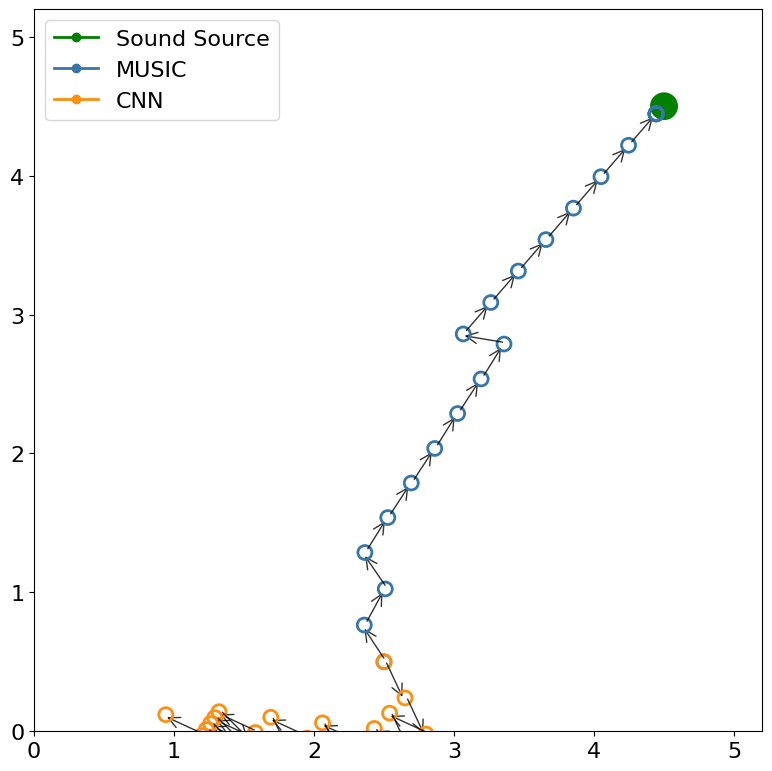

In [15]:
microphones = np.c_[[ROOM_DIM[0]/2-0.1, 0.5, 0], [ROOM_DIM[0]/2+0.1, 0.5, 0]]
source_loc = [float(4.5), float(4.5)]
centre_mic = [2.5, 0.5]

plt.rcParams.update({'figure.figsize': [8,8], 'figure.autolayout': True, 'font.size': 16})
fig, _ = plt.subplots()
ax = plt.gca()
ax.set_xlim([0, 5.2])
ax.set_ylim([0, 5.2])

# Include sound source patch
sound = patches.Circle((float(source_loc[0]), float(source_loc[1])), radius=0.1, facecolor='green', linewidth=5, label='Sound Source')
ax.add_patch(sound)

# Include custom legend
legend_elements = [Line2D([0], [0], marker='o', lw=2, color='green',   label='Sound Source'),
                   Line2D([0], [0], marker='o', lw=2, color='#3776ab', label='MUSIC'),
                   Line2D([0], [0], marker='o', lw=2, color="#ff8f0f", label='CNN')]
ax.legend(handles=legend_elements, loc='upper left')

# Initialize models
MUSIC = Model_pred('MUSIC', source_loc, centre_mic, '#3776ab')
CNN = Model_pred('CNN', source_loc, centre_mic, '#ff8f0f')
i = 0

# Generate predictions
while MUSIC.success == False or CNN.success == False:
    # Generate room
    fs, signal = wavfile.read(AUDIO_PATH)
    MUSIC.get_room(signal, ax)
    CNN.get_room(signal, ax)

    # Localize sound
    MUSIC.get_pred(ax)
    CNN.get_pred(ax)
    
    i += 1
    plt.savefig("..\\pygame\\path_ideal\\path_ideal_%02d.png"%i)
    plt.show